In [1]:
!pip install mne snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 14.8 MB/s eta 0:00:00


🔥 Using device: cuda
📊 Loading Data from Physionet... Subject [20/20]
✅ Data Loading Complete!
🧠 Extracting Geometric Features (Curvature + Tangling)...
⚡ Start Training GeoEEG-SNN V5.0 (EEGNet-Style, Max-norm, Label Smoothing)...
Epoch [001/100] | Train Loss: 27.2110 Acc: 37.0% | Test Loss: 6.9885 Acc: 49.4%
Epoch [005/100] | Train Loss: 3.0443 Acc: 39.1% | Test Loss: 2.2200 Acc: 49.3%
Epoch [010/100] | Train Loss: 1.3404 Acc: 40.8% | Test Loss: 1.7203 Acc: 50.7%
Epoch [015/100] | Train Loss: 1.3072 Acc: 41.1% | Test Loss: 1.3292 Acc: 29.2%
Epoch [020/100] | Train Loss: 1.2496 Acc: 43.9% | Test Loss: 1.2311 Acc: 50.7%
Epoch [025/100] | Train Loss: 1.2047 Acc: 46.8% | Test Loss: 1.1964 Acc: 51.0%
Epoch [030/100] | Train Loss: 1.1556 Acc: 50.7% | Test Loss: 1.0695 Acc: 55.4%
Epoch [035/100] | Train Loss: 1.1509 Acc: 52.1% | Test Loss: 1.1133 Acc: 54.3%
Epoch [040/100] | Train Loss: 1.1446 Acc: 52.3% | Test Loss: 1.0872 Acc: 56.8%
Epoch [045/100] | Train Loss: 1.1471 Acc: 53.1% | Test Lo

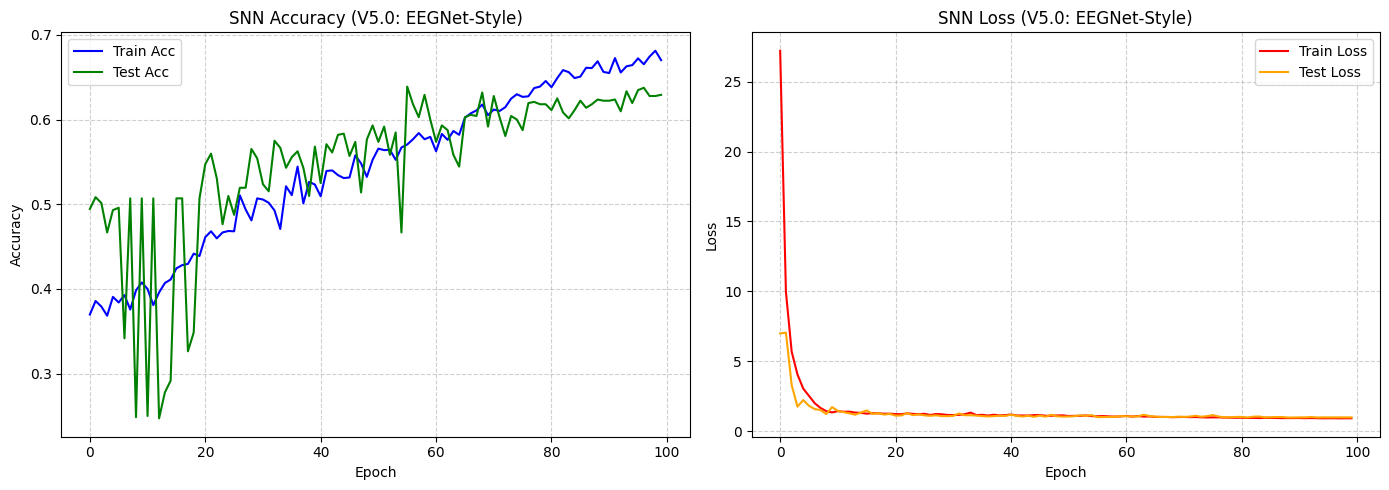

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import snntorch as snn
from snntorch import surrogate
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# MNE 자체 로그 끄기
mne.set_log_level('ERROR')

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# --- 1. 환경 설정 ---
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"🔥 Using device: {device}")

# ==========================================
# 2. Geometric Feature Extractor (오리지널 아이디어 유지)
# ==========================================
def compute_tangling_torch(x, dx, epsilon=1e-5):
    B, C, T = x.shape
    Q_list = []
    for i in range(B):
        x_diff_sq = (x[i].unsqueeze(-1) - x[i].unsqueeze(-2)).pow(2).sum(dim=0)
        dx_diff_sq = (dx[i].unsqueeze(-1) - dx[i].unsqueeze(-2)).pow(2).sum(dim=0)
        ratio = dx_diff_sq / (x_diff_sq + epsilon)
        mask = torch.eye(T, device=x.device).bool()
        ratio = ratio.masked_fill(mask, 0)
        q_val, _ = ratio.max(dim=-1)
        Q_list.append(q_val)
    return torch.stack(Q_list, dim=0).unsqueeze(1)

def extract_geometric_features_torch(data_tensor):
    n_fft = data_tensor.shape[-1]
    freq = torch.fft.fft(data_tensor, dim=-1)
    h = torch.zeros_like(freq)
    h[..., 0] = freq[..., 0]
    h[..., 1:(n_fft + 1) // 2] = 2 * freq[..., 1:(n_fft + 1) // 2]
    if n_fft % 2 == 0:
        h[..., n_fft // 2] = freq[..., n_fft // 2]
    analytic = torch.fft.ifft(h, dim=-1)
    r = analytic.real
    r_prime = torch.zeros_like(r)
    r_prime[..., 1:-1] = (r[..., 2:] - r[..., :-2]) / 2
    r_prime[..., 0] = r[..., 1] - r[..., 0]
    r_prime[..., -1] = r[..., -1] - r[..., -2]
    r_double_prime = torch.zeros_like(r_prime)
    r_double_prime[..., 1:-1] = (r_prime[..., 2:] - r_prime[..., :-2]) / 2

    num_k = torch.abs(r_prime * r_double_prime)
    den_k = torch.pow(torch.abs(r_prime), 3) + 1e-6
    curvature = num_k / den_k

    r_norm = (r - r.mean(dim=-1, keepdim=True)) / (r.std(dim=-1, keepdim=True) + 1e-6)
    v_norm = (r_prime - r_prime.mean(dim=-1, keepdim=True)) / (r_prime.std(dim=-1, keepdim=True) + 1e-6)
    tangling = compute_tangling_torch(r_norm, v_norm)

    features = torch.cat([r, curvature, tangling], dim=1)
    f_mean = features.mean(dim=(0, 2), keepdim=True)
    f_std = features.std(dim=(0, 2), keepdim=True)
    return (features - f_mean) / (f_std + 1e-6)

# ==========================================
# 3. 데이터 로드 (MNE Physionet 1~20)
# ==========================================
def load_physionet_data(subject=1):
    runs = [4, 6, 8, 10, 12, 14]
    raw_fnames = eegbci.load_data(subject, runs, verbose=False)
    raw = concatenate_raws([mne.io.read_raw_edf(f, preload=True, verbose=False) for f in raw_fnames])
    eegbci.standardize(raw)
    montage = mne.channels.make_standard_montage('standard_1005')
    raw.set_montage(montage)

    events, _ = mne.events_from_annotations(raw, verbose=False)
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
    epochs = mne.Epochs(raw, events, event_id=None, tmin=0., tmax=4.0, proj=True, picks=picks,
                        baseline=None, preload=True, verbose=False)
    labels = epochs.events[:, -1]
    unique_labels = np.unique(labels)
    label_map = {original: idx % 4 for idx, original in enumerate(unique_labels)}
    new_labels = np.array([label_map[l] for l in labels])
    return epochs.get_data(), new_labels

NUM_SUBJECTS = 20
X_list, y_list = [], []
for sub in range(1, NUM_SUBJECTS + 1):
    print(f"\r📊 Loading Data from Physionet... Subject [{sub:02d}/{NUM_SUBJECTS}]", end='', flush=True)
    with HiddenPrints():
        x, y = load_physionet_data(sub)
    X_list.append(x)
    y_list.append(y)
print("\n✅ Data Loading Complete!")

X_tensor_raw = torch.tensor(np.concatenate(X_list, axis=0), dtype=torch.float32).to(device)
y_tensor = torch.tensor(np.concatenate(y_list, axis=0), dtype=torch.long).to(device)

print("🧠 Extracting Geometric Features (Curvature + Tangling)...")
with torch.no_grad():
    X_geo = extract_geometric_features_torch(X_tensor_raw)

dataset = TensorDataset(X_geo, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ==========================================
# 4. GeoEEG SNN V5.0 (EEGNet-style Depthwise Separable)
# ==========================================
class PopulationEncoder(nn.Module):
    def __init__(self, num_neurons, min_val=-3.0, max_val=3.0, sigma=1.0):
        super().__init__()
        self.num_neurons = num_neurons
        mu = torch.linspace(min_val, max_val, num_neurons)
        self.register_buffer('mu', mu)
        self.sigma = sigma
    def forward(self, x):
        B, C, T = x.shape
        x_expanded = x.unsqueeze(-1)
        encoded = torch.exp(-((x_expanded - self.mu)**2) / (2 * self.sigma**2))
        return encoded.permute(0, 1, 3, 2).reshape(B, C * self.num_neurons, T)

class GeoEEGSNN_V5(nn.Module):
    def __init__(self, num_channels=129, num_classes=4, pop_neurons=4, beta=0.90):
        super().__init__()
        encoded_channels = num_channels * pop_neurons # 129 * 4 = 516
        self.encoder = PopulationEncoder(num_neurons=pop_neurons, min_val=-3, max_val=3, sigma=1.5)

        # [혁신 1] Temporal Depthwise Conv (채널 섞임 방지)
        self.conv_temporal = nn.Conv1d(encoded_channels, encoded_channels, kernel_size=15, padding=7, groups=encoded_channels, bias=False)
        self.in_temporal = nn.InstanceNorm1d(encoded_channels)

        # [혁신 2] Spatial Pointwise Conv (극단적 다이어트: 516 -> 32)
        self.conv_spatial = nn.Conv1d(encoded_channels, 32, kernel_size=1, bias=False)
        self.in_spatial = nn.InstanceNorm1d(32)

        self.pool_time = nn.AvgPool1d(kernel_size=4, stride=4) # T=160으로 압축
        self.dropout1d = nn.Dropout1d(p=0.4)
        self.dropout = nn.Dropout(p=0.4)

        # [혁신 3] SNN 다이어트
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc1 = nn.Linear(32, 16) # 16 채널로 병목 형성 (Bottle-neck)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc_out = nn.Linear(16, num_classes)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(), output=True)

    def forward(self, x):
        c = self.encoder(x)

        # Temporal Filter (No mixing)
        c = self.conv_temporal(c)
        c = self.in_temporal(c)
        c = torch.relu(c)

        # Spatial Filter (Channel mixing & compression)
        c = self.conv_spatial(c)
        c = self.in_spatial(c)
        c = torch.relu(c)

        c = self.pool_time(c)
        c = self.dropout1d(c)

        c_seq = c.permute(2, 0, 1) # SNN 진입 (T=160, Batch, 32)

        mem1, mem2, mem_out = self.lif1.init_leaky(), self.lif2.init_leaky(), self.lif_out.init_leaky()
        mem_rec = []

        for step in range(c_seq.size(0)):
            spk1, mem1 = self.lif1(c_seq[step], mem1)
            fc1_out = self.dropout(self.fc1(spk1))
            spk2, mem2 = self.lif2(fc1_out, mem2)
            spk_out, mem_out = self.lif_out(self.fc_out(spk2), mem_out)
            mem_rec.append(mem_out)

        return torch.stack(mem_rec, dim=0)

# 가중치 폭주 억제 유틸리티 (Max-norm)
def apply_max_norm(model, max_val=1.0):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name and len(param.shape) > 1:
                norm = param.norm(2, dim=0, keepdim=True)
                desired = torch.clamp(norm, max=max_val)
                param.mul_(desired / (norm + 1e-8))

# ==========================================
# 5. 학습 루프 (V5.0)
# ==========================================
model = GeoEEGSNN_V5(num_channels=X_geo.shape[1], num_classes=4, pop_neurons=4).to(device)

# [혁신 4] Label Smoothing으로 과도한 확신 억제
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.003, weight_decay=0.01)

num_epochs = 100
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train_acc_hist, test_acc_hist, train_loss_hist, test_loss_hist = [], [], [], []

print(f"⚡ Start Training GeoEEG-SNN V5.0 (EEGNet-Style, Max-norm, Label Smoothing)...")
for epoch in range(num_epochs):
    model.train()
    correct, total, iter_loss = 0, 0, 0
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()

        mem_rec = model(data)
        out_voltage = mem_rec.sum(dim=0)
        loss = criterion(out_voltage, targets)
        loss.backward()
        optimizer.step()

        # Max-norm 가중치 클리핑 적용
        apply_max_norm(model, max_val=1.5)

        iter_loss += loss.item()
        _, predicted = out_voltage.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    train_acc = correct / total
    train_loss = iter_loss / len(train_loader)
    scheduler.step()

    model.eval()
    t_correct, t_total, t_loss = 0, 0, 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            mem_rec = model(data)
            out_voltage = mem_rec.sum(dim=0)
            loss = criterion(out_voltage, targets)

            t_loss += loss.item()
            _, predicted = out_voltage.max(1)
            t_total += targets.size(0)
            t_correct += (predicted == targets).sum().item()

    test_acc = t_correct / t_total
    test_loss = t_loss / len(test_loader)

    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:03d}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc*100:.1f}% | "
              f"Test Loss: {test_loss:.4f} Acc: {test_acc*100:.1f}%")

print("🎉 V5.0 학습 완료! 진동이 줄어들고 안정적으로 올라가는지 궤적을 확인해보자.")

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label='Train Acc', color='blue')
plt.plot(test_acc_hist, label='Test Acc', color='green')
plt.title("SNN Accuracy (V5.0: EEGNet-Style)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label='Train Loss', color='red')
plt.plot(test_loss_hist, label='Test Loss', color='orange')
plt.title("SNN Loss (V5.0: EEGNet-Style)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import snntorch as snn
from snntorch import surrogate
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import copy

# [유지] 구글 드라이브 연동 (다운로드 속도 최적화)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    mne_data_dir = '/content/drive/MyDrive/mne_data'
    os.makedirs(mne_data_dir, exist_ok=True)
    mne.set_config('MNE_DATA', mne_data_dir)
except ImportError:
    print("Colab 환경이 아닙니다. 로컬 다운로드를 진행합니다.")

mne.set_log_level('ERROR')

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"🔥 Using device: {device}")

# ==========================================
# 1. Geometric Feature Extractor (오리지널 아이디어)
# ==========================================
def compute_tangling_torch(x, dx, epsilon=1e-5):
    B, C, T = x.shape
    Q_list = []
    for i in range(B):
        x_diff_sq = (x[i].unsqueeze(-1) - x[i].unsqueeze(-2)).pow(2).sum(dim=0)
        dx_diff_sq = (dx[i].unsqueeze(-1) - dx[i].unsqueeze(-2)).pow(2).sum(dim=0)
        ratio = dx_diff_sq / (x_diff_sq + epsilon)
        mask = torch.eye(T, device=x.device).bool()
        ratio = ratio.masked_fill(mask, 0)
        q_val, _ = ratio.max(dim=-1)
        Q_list.append(q_val)
    return torch.stack(Q_list, dim=0).unsqueeze(1)

def extract_geometric_features_torch(data_tensor):
    n_fft = data_tensor.shape[-1]
    freq = torch.fft.fft(data_tensor, dim=-1)
    h = torch.zeros_like(freq)
    h[..., 0] = freq[..., 0]
    h[..., 1:(n_fft + 1) // 2] = 2 * freq[..., 1:(n_fft + 1) // 2]
    if n_fft % 2 == 0:
        h[..., n_fft // 2] = freq[..., n_fft // 2]
    analytic = torch.fft.ifft(h, dim=-1)
    r = analytic.real
    r_prime = torch.zeros_like(r)
    r_prime[..., 1:-1] = (r[..., 2:] - r[..., :-2]) / 2
    r_prime[..., 0] = r[..., 1] - r[..., 0]
    r_prime[..., -1] = r[..., -1] - r[..., -2]
    r_double_prime = torch.zeros_like(r_prime)
    r_double_prime[..., 1:-1] = (r_prime[..., 2:] - r_prime[..., :-2]) / 2

    num_k = torch.abs(r_prime * r_double_prime)
    den_k = torch.pow(torch.abs(r_prime), 3) + 1e-6
    curvature = num_k / den_k

    r_norm = (r - r.mean(dim=-1, keepdim=True)) / (r.std(dim=-1, keepdim=True) + 1e-6)
    v_norm = (r_prime - r_prime.mean(dim=-1, keepdim=True)) / (r_prime.std(dim=-1, keepdim=True) + 1e-6)
    tangling = compute_tangling_torch(r_norm, v_norm)

    features = torch.cat([r, curvature, tangling], dim=1)
    f_mean = features.mean(dim=(0, 2), keepdim=True)
    f_std = features.std(dim=(0, 2), keepdim=True)
    return (features - f_mean) / (f_std + 1e-6)

# ==========================================
# 2. 데이터 로드 및 분할 (Pre-train vs Fine-tune)
# ==========================================
def load_physionet_data(subject=1):
    runs = [4, 6, 8, 10, 12, 14]
    raw_fnames = eegbci.load_data(subject, runs, verbose=False)
    raw = concatenate_raws([mne.io.read_raw_edf(f, preload=True, verbose=False) for f in raw_fnames])
    eegbci.standardize(raw)
    montage = mne.channels.make_standard_montage('standard_1005')
    raw.set_montage(montage)
    events, _ = mne.events_from_annotations(raw, verbose=False)
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
    epochs = mne.Epochs(raw, events, event_id=None, tmin=0., tmax=4.0, proj=True, picks=picks, baseline=None, preload=True, verbose=False)
    labels = epochs.events[:, -1]
    unique_labels = np.unique(labels)
    label_map = {original: idx % 4 for idx, original in enumerate(unique_labels)}
    return epochs.get_data(), np.array([label_map[l] for l in labels])

NUM_SUBJECTS = 20
TARGET_SUBJECT = 20 # 마지막 20번 피험자를 타겟으로 설정

X_pre, y_pre = [], []
X_target, y_target = None, None

for sub in range(1, NUM_SUBJECTS + 1):
    print(f"\r📊 Loading Data... Subject [{sub:02d}/{NUM_SUBJECTS}]", end='', flush=True)
    with HiddenPrints():
        x, y = load_physionet_data(sub)
    if sub == TARGET_SUBJECT:
        X_target, y_target = x, y
    else:
        X_pre.append(x)
        y_pre.append(y)
print("\n✅ Data Loading Complete!")

# Pre-train 데이터 (1~19번)
X_pre_tensor = torch.tensor(np.concatenate(X_pre, axis=0), dtype=torch.float32).to(device)
y_pre_tensor = torch.tensor(np.concatenate(y_pre, axis=0), dtype=torch.long).to(device)
with torch.no_grad():
    X_pre_geo = extract_geometric_features_torch(X_pre_tensor)
pre_loader = DataLoader(TensorDataset(X_pre_geo, y_pre_tensor), batch_size=32, shuffle=True)

# Fine-tune 타겟 데이터 (20번 피험자) - Train 70%, Test 30% 분할
X_tgt_tensor = torch.tensor(X_target, dtype=torch.float32).to(device)
y_tgt_tensor = torch.tensor(y_target, dtype=torch.long).to(device)
with torch.no_grad():
    X_tgt_geo = extract_geometric_features_torch(X_tgt_tensor)

tgt_dataset = TensorDataset(X_tgt_geo, y_tgt_tensor)
ft_train_size = int(0.7 * len(tgt_dataset))
ft_test_size = len(tgt_dataset) - ft_train_size
ft_train_dataset, ft_test_dataset = torch.utils.data.random_split(tgt_dataset, [ft_train_size, ft_test_size])

ft_train_loader = DataLoader(ft_train_dataset, batch_size=16, shuffle=True)
ft_test_loader = DataLoader(ft_test_dataset, batch_size=16, shuffle=False)

# ==========================================
# 3. GeoEEG SNN V5.0 Architecture (검증된 안정적 모델)
# ==========================================
class PopulationEncoder(nn.Module):
    def __init__(self, num_neurons, min_val=-3.0, max_val=3.0, sigma=1.0):
        super().__init__()
        self.num_neurons = num_neurons
        mu = torch.linspace(min_val, max_val, num_neurons)
        self.register_buffer('mu', mu)
        self.sigma = sigma
    def forward(self, x):
        B, C, T = x.shape
        x_expanded = x.unsqueeze(-1)
        encoded = torch.exp(-((x_expanded - self.mu)**2) / (2 * self.sigma**2))
        return encoded.permute(0, 1, 3, 2).reshape(B, C * self.num_neurons, T)

class GeoEEGSNN_V5(nn.Module):
    def __init__(self, num_channels=129, num_classes=4, pop_neurons=4, beta=0.90):
        super().__init__()
        encoded_channels = num_channels * pop_neurons
        self.encoder = PopulationEncoder(num_neurons=pop_neurons, min_val=-3, max_val=3, sigma=1.5)

        self.conv_temporal = nn.Conv1d(encoded_channels, encoded_channels, kernel_size=15, padding=7, groups=encoded_channels, bias=False)
        self.in_temporal = nn.InstanceNorm1d(encoded_channels)
        self.conv_spatial = nn.Conv1d(encoded_channels, 32, kernel_size=1, bias=False)
        self.in_spatial = nn.InstanceNorm1d(32)

        self.pool_time = nn.AvgPool1d(kernel_size=4, stride=4)
        self.dropout1d = nn.Dropout1d(p=0.4)
        self.dropout = nn.Dropout(p=0.4)

        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc1 = nn.Linear(32, 16)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc_out = nn.Linear(16, num_classes)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(), output=True)

    def forward(self, x):
        c = self.encoder(x)
        c = torch.relu(self.in_temporal(self.conv_temporal(c)))
        c = torch.relu(self.in_spatial(self.conv_spatial(c)))
        c = self.dropout1d(self.pool_time(c))
        c_seq = c.permute(2, 0, 1)

        mem1, mem2, mem_out = self.lif1.init_leaky(), self.lif2.init_leaky(), self.lif_out.init_leaky()
        mem_rec = []
        for step in range(c_seq.size(0)):
            spk1, mem1 = self.lif1(c_seq[step], mem1)
            fc1_out = self.dropout(self.fc1(spk1))
            spk2, mem2 = self.lif2(fc1_out, mem2)
            spk_out, mem_out = self.lif_out(self.fc_out(spk2), mem_out)
            mem_rec.append(mem_out)
        return torch.stack(mem_rec, dim=0)

def apply_max_norm(model, max_val=1.0):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name and len(param.shape) > 1:
                norm = param.norm(2, dim=0, keepdim=True)
                desired = torch.clamp(norm, max=max_val)
                param.mul_(desired / (norm + 1e-8))

# ==========================================
# 4. 학습 루프 (Stage 1: Pre-training)
# ==========================================
model = GeoEEGSNN_V5(num_channels=X_pre_geo.shape[1], num_classes=4).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Pre-train 설정 (19명 데이터로 일반화 특징 학습)
pre_epochs = 60
optimizer_pre = torch.optim.AdamW(model.parameters(), lr=0.003, weight_decay=0.01)
scheduler_pre = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_pre, T_max=pre_epochs)

print(f"\n🚀 [STAGE 1] Pre-training on 19 Subjects (General Geometric Rules)...")
for epoch in range(pre_epochs):
    model.train()
    correct, total, iter_loss = 0, 0, 0
    for data, targets in pre_loader:
        data, targets = data.to(device), targets.to(device)
        optimizer_pre.zero_grad()
        mem_rec = model(data)
        out_voltage = mem_rec.sum(dim=0)
        loss = criterion(out_voltage, targets)
        loss.backward()
        optimizer_pre.step()
        apply_max_norm(model, max_val=1.5)

        iter_loss += loss.item()
        _, predicted = out_voltage.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    scheduler_pre.step()
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Pre-train Epoch [{epoch+1:03d}/{pre_epochs}] | Loss: {iter_loss/len(pre_loader):.4f} | Acc: {correct/total*100:.1f}%")

# ==========================================
# 5. 학습 루프 (Stage 2: Fine-tuning)
# ==========================================
# Fine-tune 설정 (타겟 피험자에게 맞춤화, 학습률을 1/10로 대폭 낮춤)
ft_epochs = 30
optimizer_ft = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)

ft_test_acc_hist = []

print(f"\n🎯 [STAGE 2] Fine-tuning on Target Subject 20 (Personalization)...")
for epoch in range(ft_epochs):
    model.train()
    for data, targets in ft_train_loader:
        data, targets = data.to(device), targets.to(device)
        optimizer_ft.zero_grad()
        mem_rec = model(data)
        loss = criterion(mem_rec.sum(dim=0), targets)
        loss.backward()
        optimizer_ft.step()
        apply_max_norm(model, max_val=1.5)

    # 타겟 피험자 Test 검증
    model.eval()
    t_correct, t_total = 0, 0
    with torch.no_grad():
        for data, targets in ft_test_loader:
            data, targets = data.to(device), targets.to(device)
            out_voltage = model(data).sum(dim=0)
            _, predicted = out_voltage.max(1)
            t_total += targets.size(0)
            t_correct += (predicted == targets).sum().item()

    test_acc = t_correct / t_total
    ft_test_acc_hist.append(test_acc)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Fine-tune Epoch [{epoch+1:03d}/{ft_epochs}] | Target Test Acc: {test_acc*100:.1f}%")

print(f"\n🎉 훈련 완료! Target Subject 최종 Accuracy: {ft_test_acc_hist[-1]*100:.1f}%")

# Fine-tuning 성능 그래프
plt.figure(figsize=(7, 5))
plt.plot(ft_test_acc_hist, label='Target Subject Test Acc', color='magenta', linewidth=2)
plt.axhline(y=0.7, color='r', linestyle='--', label='70% Threshold')
plt.title("Fine-tuning Accuracy on Target Subject")
plt.xlabel("Fine-tune Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Mounted at /content/drive
📁 MNE Data Path set to: /content/drive/MyDrive/mne_data (이제 다운로드는 최초 1회만 진행됨!)
🔥 Using device: cuda
📊 Loading Data (Drive Caching)... Subject [20/20]
✅ Data Loading Complete!
🧠 Extracting Geometric Features...
⚡ Start Training GeoEEG-SNN V5.2 (PLIF + Manifold Mixup)...
Epoch [001/120] | Train Loss: 21.8348 Acc: 34.3% | Test Loss: 6.3940 Acc: 47.6%
Epoch [005/120] | Train Loss: 2.3923 Acc: 40.7% | Test Loss: 1.3700 Acc: 42.1%
Epoch [010/120] | Train Loss: 1.4999 Acc: 42.1% | Test Loss: 1.3742 Acc: 27.5%
Epoch [015/120] | Train Loss: 1.2900 Acc: 44.0% | Test Loss: 1.1868 Acc: 39.4%
Epoch [020/120] | Train Loss: 1.2145 Acc: 47.2% | Test Loss: 1.8489 Acc: 13.9%
Epoch [025/120] | Train Loss: 1.1750 Acc: 49.7% | Test Loss: 1.4560 Acc: 23.9%
